In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

Dataset saved to test_timeseries_data.csv


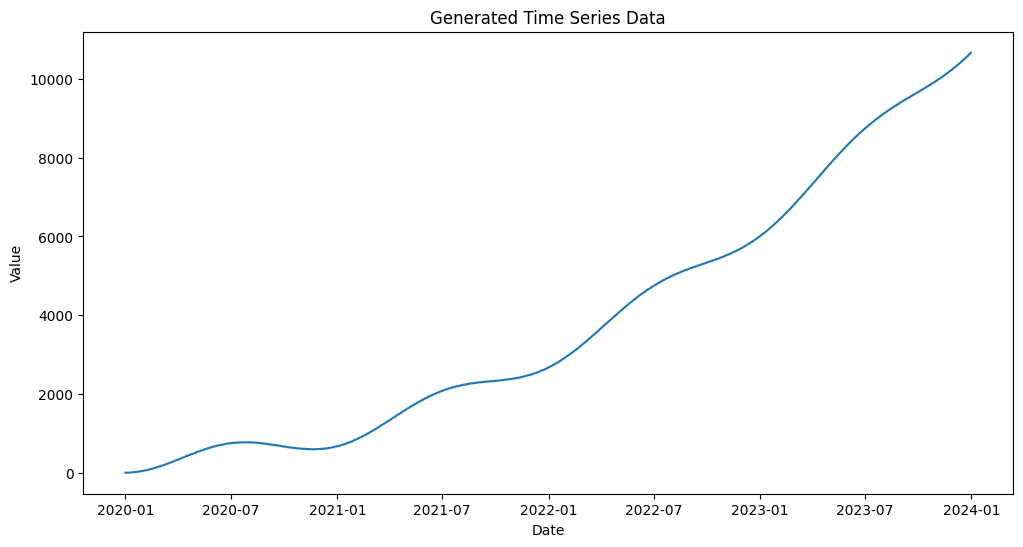

,ds,y,category1,category2
0,2020-01-01,0.948348,A,Y
1,2020-01-02,1.060144,A,Y
2,2020-01-03,1.247286,A,Y
3,2020-01-04,3.703106,C,X
4,2020-01-05,-0.471373,B,Z
...,...,...,...,...
1456,2023-12-27,10609.205155,B,X
1457,2023-12-28,10623.317945,C,X
1458,2023-12-29,10630.980617,A,Z
1459,2023-12-30,10651.947097,C,X


In [2]:
def generate_test_dataset(start_date, end_date, noise_level=0.1):
    # Generate date range
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Create base dataframe
    df = pd.DataFrame({'ds': date_range})

    # Generate target variable (y) with trend, seasonality, and noise
    t = np.arange(len(df))
    y_trend = 0.01 * t
    y_seasonal = 5 * np.sin(2 * np.pi * t / 365.25)  # Yearly seasonality
    y_noise = noise_level * np.random.randn(len(df))
    df['y'] = y_trend + y_seasonal + y_noise
    df['y'] = df['y'].cumsum()  # Make it cumulative to resemble a real time series

    # Generate categorical variables
    df['category1'] = np.random.choice(['A', 'B', 'C'], len(df))
    df['category2'] = np.random.choice(['X', 'Y', 'Z'], len(df))

    # Add category effects
    category_effects = {
        'A': -1, 'B': 1, 'C': 1,
        'X': 2, 'Y': 2, 'Z': -2.5
    }
    df['y'] += df['category1'].map(category_effects) + df['category2'].map(category_effects)

    return df

# Generate dataset
start_date = '2020-01-01'
end_date = '2023-12-31'
df = generate_test_dataset(start_date, end_date)

# Save to CSV
csv_filename = 'test_timeseries_data.csv'
df.to_csv(csv_filename, index=False)
print(f"Dataset saved to {csv_filename}")

# Optional: Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'])
plt.title('Generated Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

df

In [3]:
data = pd.read_csv('/content/test_timeseries_data.csv')

In [4]:
data = data.rename(columns={'date_column': 'ds', 'target_column': 'y'})

# Convert date column to datetime
data['ds'] = pd.to_datetime(data['ds'])

data

,ds,y,category1,category2
0,2020-01-01,0.948348,A,Y
1,2020-01-02,1.060144,A,Y
2,2020-01-03,1.247286,A,Y
3,2020-01-04,3.703106,C,X
4,2020-01-05,-0.471373,B,Z
...,...,...,...,...
1456,2023-12-27,10609.205155,B,X
1457,2023-12-28,10623.317945,C,X
1458,2023-12-29,10630.980617,A,Z
1459,2023-12-30,10651.947097,C,X


In [5]:
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns = [col for col in categorical_columns if col not in ['ds']]

# Use LabelEncoder to convert categorical variables to numeric
le = LabelEncoder()
for col in categorical_columns:
    data[col] = le.fit_transform(data[col])

    # Add categorical columns as additional regressors
    data[f'{col}_regressor'] = data[col]

In [6]:
# Step 5: Create and fit the model
model = Prophet()

# Add the categorical columns as regressors
for col in categorical_columns:
    model.add_regressor(f'{col}_regressor')

model.fit(data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcsogy3ya/10vk33yk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcsogy3ya/oya9o2x3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12356', 'data', 'file=/tmp/tmpcsogy3ya/10vk33yk.json', 'init=/tmp/tmpcsogy3ya/oya9o2x3.json', 'output', 'file=/tmp/tmpcsogy3ya/prophet_modelz6d52itd/prophet_model-20240725055544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:55:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:55:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [7]:
future_periods = 365  # Predict for the next year
future = model.make_future_dataframe(periods=future_periods)

# Add the categorical columns to the future dataframe
for col in categorical_columns:
    future[f'{col}_regressor'] = data[f'{col}_regressor'].iloc[-1]  # Use the last known value

# Step 7: Make predictions
forecast = model.predict(future)

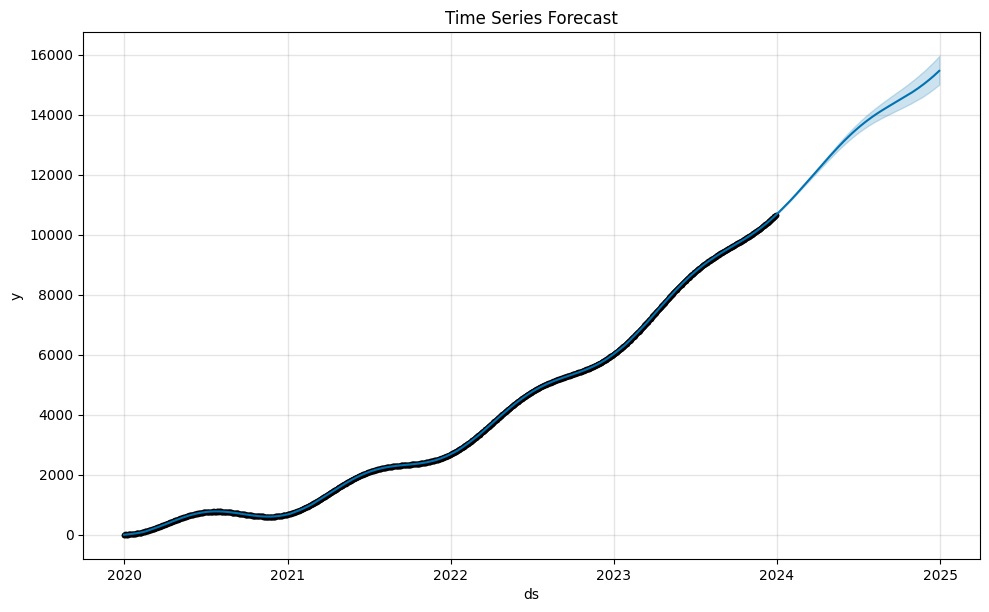

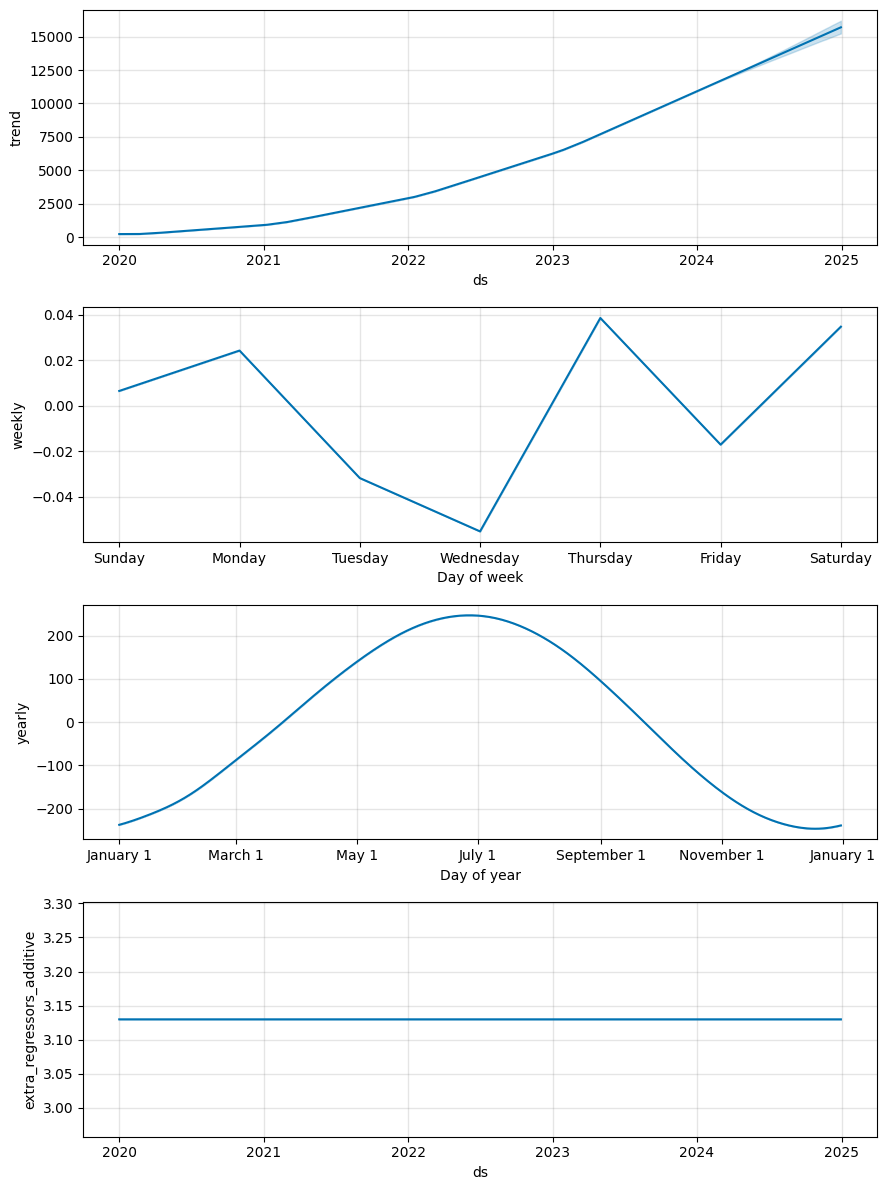

In [8]:
# Step 8: Visualize the results
fig1 = model.plot(forecast)
plt.title('Time Series Forecast')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

In [9]:
# Step 9: Print the forecast for the next 10 days
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper'] +
              [f'{col}_regressor' for col in categorical_columns]].tail(10))

# Step 10: Evaluate the model (optional)
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

# Calculate performance metrics
df_p = performance_metrics(df_cv)
print(df_p)

INFO:prophet:Making 3 forecasts with cutoffs between 2022-01-05 00:00:00 and 2022-12-31 00:00:00


             ds          yhat    yhat_lower    yhat_upper  \
1816 2024-12-21  15335.440588  14894.565063  15812.108862   
1817 2024-12-22  15348.901908  14906.206544  15827.981963   
1818 2024-12-23  15362.501870  14915.116959  15843.932366   
1819 2024-12-24  15376.119776  14928.339391  15856.988825   
1820 2024-12-25  15389.860324  14941.987397  15875.856432   
1821 2024-12-26  15403.806087  14952.599899  15890.768878   
1822 2024-12-27  15417.688294  14965.834494  15908.665048   
1823 2024-12-28  15431.760765  14974.573786  15925.734431   
1824 2024-12-29  15445.832963  14986.374270  15939.907992   
1825 2024-12-30  15460.027273  14999.551752  15956.937277   

      category1_regressor  category2_regressor  
1816             0.995759             2.134184  
1817             0.995759             2.134184  
1818             0.995759             2.134184  
1819             0.995759             2.134184  
1820             0.995759             2.134184  
1821             0.995759         

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcsogy3ya/bcgvpjtq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcsogy3ya/98wt4esf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53438', 'data', 'file=/tmp/tmpcsogy3ya/bcgvpjtq.json', 'init=/tmp/tmpcsogy3ya/98wt4esf.json', 'output', 'file=/tmp/tmpcsogy3ya/prophet_modelhilbdz0l/prophet_model-20240725055602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:56:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:56:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcsogy3ya/hlev3rwz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcsogy3ya/uipymhsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

     horizon            mse        rmse         mae      mape     mdape  \
0    37 days     144.362224   12.015083    9.511107  0.002123  0.001695   
1    38 days     158.921576   12.606410   10.093192  0.002250  0.001747   
2    39 days     175.232319   13.237534   10.709342  0.002386  0.001887   
3    40 days     192.389456   13.870453   11.309553  0.002518  0.002032   
4    41 days     211.212151   14.533140   11.919957  0.002649  0.002138   
..       ...            ...         ...         ...       ...       ...   
324 361 days  788265.692659  887.843282  881.345393  0.110334  0.101451   
325 362 days  794736.281965  891.479827  885.008236  0.110635  0.101715   
326 363 days  801217.272099  895.107408  888.659678  0.110935  0.102101   
327 364 days  807721.958775  898.733530  892.310692  0.111233  0.102242   
328 365 days  814282.862974  902.376231  895.976971  0.111530  0.102274   

        smape  coverage  
0    0.002127  0.146789  
1    0.002254  0.119266  
2    0.002391  0.0978